In [54]:
# импортирование необходимых библиотек
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns
from scipy.signal import savgol_filter
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras import optimizers
import xgboost as XGBRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import math
import functions
import joblib

In [15]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17275723206531233749
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1429923430
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12655141023264663515
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [28]:
# загрузка данных
data1 = pd.read_csv('USROP_A 2 N-SH_F-14d.csv')
data2 = pd.read_csv('USROP_A 3 N-SH-F-15d.csv')
data3 = pd.read_csv('USROP_A 4 N-SH_F-15Sd.csv')
data4 = pd.read_csv('USROP_A 1 N-S_F-7d.csv')


In [29]:
# Cглаживание тестовых данных
def data_smoothing(data): 
    data['Rate of Penetration m/h'] = savgol_filter(data['Rate of Penetration m/h'].values,89,3)
    data['Average Hookload kkgf'] = savgol_filter(data['Average Hookload kkgf'].values,101,3)
    data['Weight on Bit kkgf'] = savgol_filter(data['Weight on Bit kkgf'].values,101,3)
    data['Average Rotary Speed rpm'] = savgol_filter(data['Average Rotary Speed rpm'].values,101,3)
    data['USROP Gamma gAPI'] = savgol_filter(data['USROP Gamma gAPI'].values,101,3)
    data['Average Standpipe Pressure kPa'] = savgol_filter(data['Average Standpipe Pressure kPa'].values,101,3)
    data['Average Surface Torque kN.m'] = savgol_filter(data['Average Surface Torque kN.m'].values,101,3)
    return data

In [47]:
rc = RobustScaler()
ROP = rc.fit_transform(data1['Rate of Penetration m/h'].values.reshape(-1,1))
ROP

array([[-0.49860527],
       [-0.49860527],
       [-0.49860527],
       ...,
       [-0.46608658],
       [-0.47041259],
       [-0.47448674]])

In [49]:
def ROP_encoding_xgboost(data):
    
    rc = RobustScaler()
    ROP = rc.fit_transform(data['Rate of Penetration m/h'].values.reshape(-1,1))
    
    return ROP,rc
       
data1['Rate of Penetration m/h'],scaler1 = ROP_encoding_xgboost(data1)
data2['Rate of Penetration m/h'],scaler2 = ROP_encoding_xgboost(data2)
data3['Rate of Penetration m/h'],scaler3 = ROP_encoding_xgboost(data3)
data4['Rate of Penetration m/h'],scaler4 = ROP_encoding_xgboost(data4)

def test_preprocces_for_xgboost(data):
    test = data_smoothing(data)
    y_test = np.array(test['Rate of Penetration m/h'])
    test_1= test.drop(labels='Unnamed: 0',axis=1)
    x_test = np.array(test_1)
    return x_test,y_test
    
x_train1,y_train1=test_preprocces_for_xgboost(data1)
x_train2,y_train2=test_preprocces_for_xgboost(data2)
x_train3,y_train3=test_preprocces_for_xgboost(data3)
x_train4,y_train4=test_preprocces_for_xgboost(data4)

In [52]:
clf =XGBRegressor(learning_rate= 0.1, n_estimators = 1000,subsample =0.8,max_depth=20, min_child_weight=2, colsample_bytree=0.5)


param_grid = {'learning_rate': [0.5],
              'n_estimators':[200,500,800],
              'subsample': [0.5,0.8],
            'max_depth': [5,10],       
              'max_delta_step': [2],
              'reg_lambda': [1],
              'min_child_weight': [1,2],
              'colsample_bytree': [0.5,1]
       }
model_tuning = clf.fit(x_train1,y_train1)
model_tuning = clf.fit(x_train2,y_train2)
model_tuning = clf.fit(x_train3,y_train3)
model_tuning = clf.fit(x_train4,y_train4)


In [55]:

#save model
joblib.dump(model_tuning, "pima.joblib.dat")

#load saved model
#xgb = joblib.load(filename)

['pima.joblib.dat']

In [60]:
# тестирование модели
test = pd.read_csv('USROP_A 1 N-S_F-7d.csv')

def ROP_encoding_xgboost(data):
    
    rc = RobustScaler()
    ROP = rc.fit_transform(data['Rate of Penetration m/h'].values.reshape(-1,1))
    
    return ROP,rc
test['Rate of Penetration m/h'],test_scaler = ROP_encoding_xgboost(test)

def test_preprocces_for_xgboost(data):
    test = data_smoothing(data)
    y_test = np.array(test['Rate of Penetration m/h'])
    test_1= test.drop(labels='Unnamed: 0',axis=1)
    x_test = np.array(test_1)
    return x_test,y_test
x_test,y_test=test_preprocces_for_xgboost(test)

In [61]:
xgboost_pred = model_tuning.predict(x_test)

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


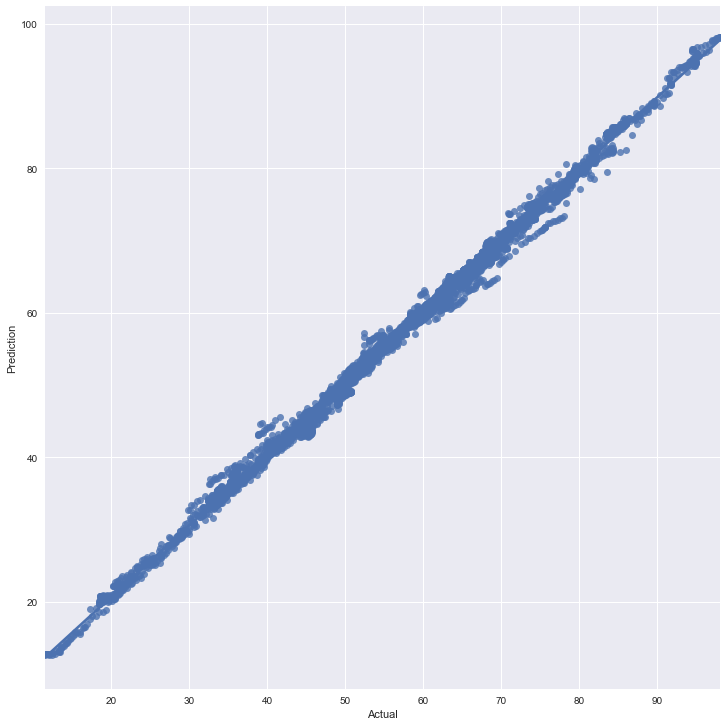

In [76]:
plt.style.use('seaborn')
y_test_plot = test_scaler.inverse_transform(y_test.reshape(-1,1))
pred_plot = test_scaler.inverse_transform(xgboost_pred.reshape(-1,1))


pred = pd.DataFrame(data=y_test_plot,columns=['Actual'])
pred['Prediction'] = pred_plot
sns.lmplot('Actual','Prediction',pred, height=10)

In [78]:
# расчет метрик
rmse = np.sqrt(np.mean(pred_plot-y_test_plot)**2)


r2 = r2_score(y_test_plot,pred_plot)
print('RMSE=',round(rmse,2),'R2_SCORE=',round(r2,2))

RMSE= 0.26 R2_SCORE= 1.0


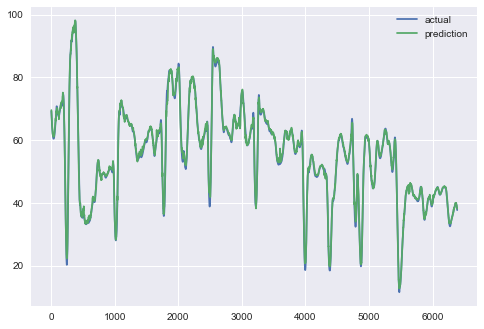

In [84]:
plt.plot(y_test_plot,label='actual')
plt.plot(pred_plot,label='prediction')
plt.legend()

In [85]:
# тестирование модели
test = pd.read_csv('USROP_A 5 N-SH-F-5d.csv')

def ROP_encoding_xgboost(data):
    
    rc = RobustScaler()
    ROP = rc.fit_transform(data['Rate of Penetration m/h'].values.reshape(-1,1))
    
    return ROP,rc
test['Rate of Penetration m/h'],test_scaler = ROP_encoding_xgboost(test)

def test_preprocces_for_xgboost(data):
    test = data_smoothing(data)
    y_test = np.array(test['Rate of Penetration m/h'])
    test_1= test.drop(labels='Unnamed: 0',axis=1)
    x_test = np.array(test_1)
    return x_test,y_test
x_test,y_test=test_preprocces_for_xgboost(test)

In [86]:
xgboost_pred = model_tuning.predict(x_test)

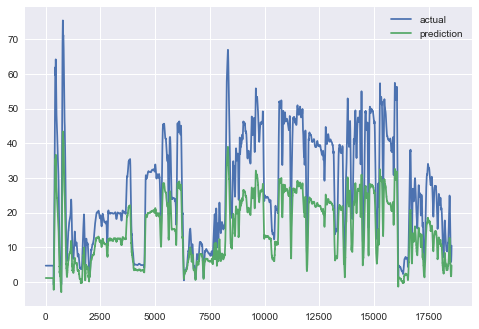

In [89]:
plt.style.use('seaborn')
y_test_plot = test_scaler.inverse_transform(y_test.reshape(-1,1))
pred_plot = test_scaler.inverse_transform(xgboost_pred.reshape(-1,1))


plt.plot(y_test_plot,label='actual')
plt.plot(pred_plot,label='prediction')
plt.legend()